# Import libraries

In [1]:
# Manipulate date
import pandas as pd 
import numpy as np
# Visualize data 
import matplotlib.pyplot as plt
# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import model_from_json
from keras.layers import Dense, Flatten,Conv2D , MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Performance metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image

2023-03-14 16:56:12.620770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train test split

In [2]:
# Train data
train_data = ImageDataGenerator(
    rescale=1./255, # Re-scale pictures from 0 to 1
    validation_split=0.2) # Train/test split

In [3]:
train_data  = train_data.flow_from_directory(
    '/Users/pabloalonsomedrano/Desktop/Eurosat/2750',
    target_size=(64, 64),
    batch_size=200,
    class_mode='sparse',
    shuffle=True,
    seed=42,
    subset='training')

Found 21600 images belonging to 10 classes.


In [4]:
# Test data
test_data = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [5]:
test_data = test_data.flow_from_directory(
    '/Users/pabloalonsomedrano/Desktop/Eurosat/2750',
    target_size=(64, 64),
    batch_size=200,
    class_mode='sparse',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 5400 images belonging to 10 classes.


# Model creation

A `Convolutional Neural Network` consists of two parts:

* `Base` which is used to extract features from an image

* `Head` determines the class of the image

When creating a model we have two options:

1. Transfer learning: uisng a model that has already been built. (VGG16, VGG19, ResNet50)

2. Creating a model from scratch. 

 B. Model from scratch

`Convolutional Neural Networks` use two type of layers:

1. `Conv2D` applies a filter(kernel) to the input images to create a feature map, helping identify patterns in data. 

* `filters` the number of output filters

* `kernel_size` height and widith

* `kernel_size` height and widht of the convolutioning window

* `stride` distance the window moves at each step in both directions, high quality (1,1)

* `padding` what to do at the boundaries of the input.


2. `MaxPool2D` condenses the feature maps to enhance the features.

* `pool_size` height and width of the pooling wind

* Also includes stride and padding

In [6]:
# Create the model
model = keras.Sequential([

    # First Convolutional Block 
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  input_shape=[64,64, 3]), #[height, width, color channels(RGB)]
    BatchNormalization(axis=-1),
    MaxPool2D(pool_size = 2,strides=5,padding = 'same'),

    # Second Convolutional Block
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=5, activation="relu", padding='same'),
    MaxPool2D(pool_size = 2,strides=5,padding = 'same'),

    # Classifier Head
    Flatten(),
    Dense(units=32, activation="relu"),
    Dense(units=10, activation="softmax"),
])

2023-03-14 16:56:15.464896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, 
                                                  patience=20,restore_best_weights=True)

In [8]:
# Compile the model
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [9]:
history = model.fit(
    train_data,
    validation_data= [test_data],
    epochs=15,
    batch_size = 200, 
    verbose=1,
)

Epoch 1/15
108/108 [==============================] - 43s 397ms/step - loss: 1.1440 - sparse_categorical_accuracy: 0.5996 - val_loss: 2.7626 - val_sparse_categorical_accuracy: 0.1883
Epoch 2/15
108/108 [==============================] - 48s 440ms/step - loss: 0.7097 - sparse_categorical_accuracy: 0.7463 - val_loss: 2.9679 - val_sparse_categorical_accuracy: 0.2448
Epoch 3/15
108/108 [==============================] - 51s 469ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.7950 - val_loss: 2.3947 - val_sparse_categorical_accuracy: 0.3193
Epoch 4/15
108/108 [==============================] - 51s 473ms/step - loss: 0.4936 - sparse_categorical_accuracy: 0.8238 - val_loss: 1.0113 - val_sparse_categorical_accuracy: 0.6219
Epoch 5/15
108/108 [==============================] - 52s 478ms/step - loss: 0.4289 - sparse_categorical_accuracy: 0.8469 - val_loss: 0.5632 - val_sparse_categorical_accuracy: 0.7965
Epoch 6/15
108/108 [==============================] - 52s 479ms/step - loss: 0.3957 -

# Performance

Minimum validation loss: 0.5102053284645081


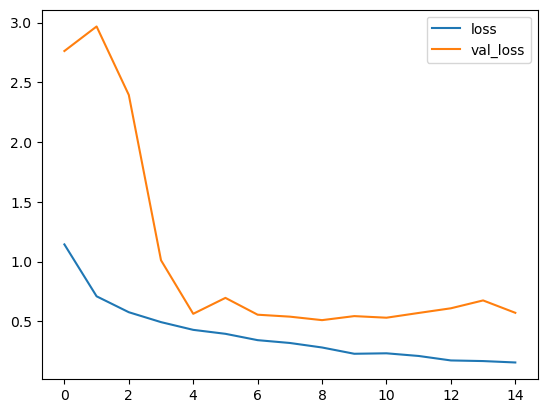

In [10]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Maximum accuracy: 0.8320370316505432


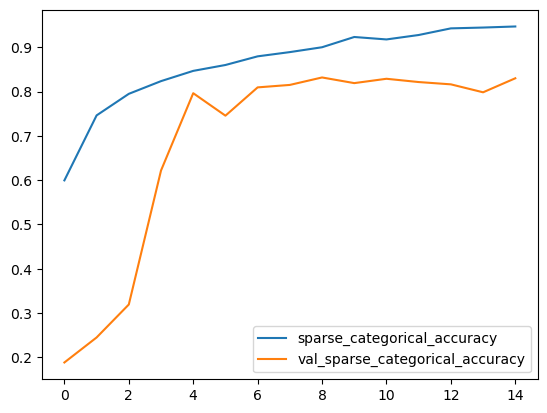

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();
print("Maximum accuracy: {}".format(history_df['val_sparse_categorical_accuracy'].max()))

# Save and load the model

In [12]:
from tensorflow.keras.models import load_model

In [13]:
model.save("my_model")
loaded_model = load_model("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [14]:
val_data = ImageDataGenerator(rescale = 1./255)
val_data = val_data.flow_from_directory('/Users/pabloalonsomedrano/Desktop/Eurosat/Eurosat/val', 
target_size=(64,64), batch_size=200, class_mode='sparse')

Found 2700 images belonging to 10 classes.


In [15]:
# Compile the model
loaded_model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [16]:
# Compile the model
loaded_model.predict(val_data)

14/14 [==============================] - 3s 182ms/step


array([[4.9503320e-03, 1.2328357e-05, 4.0684301e-01, ..., 6.5239209e-07,
        1.6709809e-04, 3.2112814e-06],
       [6.0700602e-04, 3.6628744e-08, 3.2654181e-04, ..., 2.3812501e-09,
        1.8753641e-03, 1.5442065e-06],
       [2.8446784e-06, 6.7100481e-10, 4.9444610e-05, ..., 7.7723203e-11,
        9.9975878e-01, 1.4548893e-05],
       ...,
       [5.1265043e-01, 6.2917848e-12, 5.6034373e-06, ..., 4.6151570e-13,
        4.6754161e-01, 5.8054277e-11],
       [2.3240684e-02, 3.8406394e-02, 2.1946697e-02, ..., 2.8331837e-05,
        5.1678743e-02, 2.2598819e-07],
       [1.0930180e-09, 1.2929758e-04, 9.9776162e-06, ..., 2.8956610e-11,
        1.5869540e-08, 9.9986064e-01]], dtype=float32)

14/14 [==============================] - 2s 168ms/step


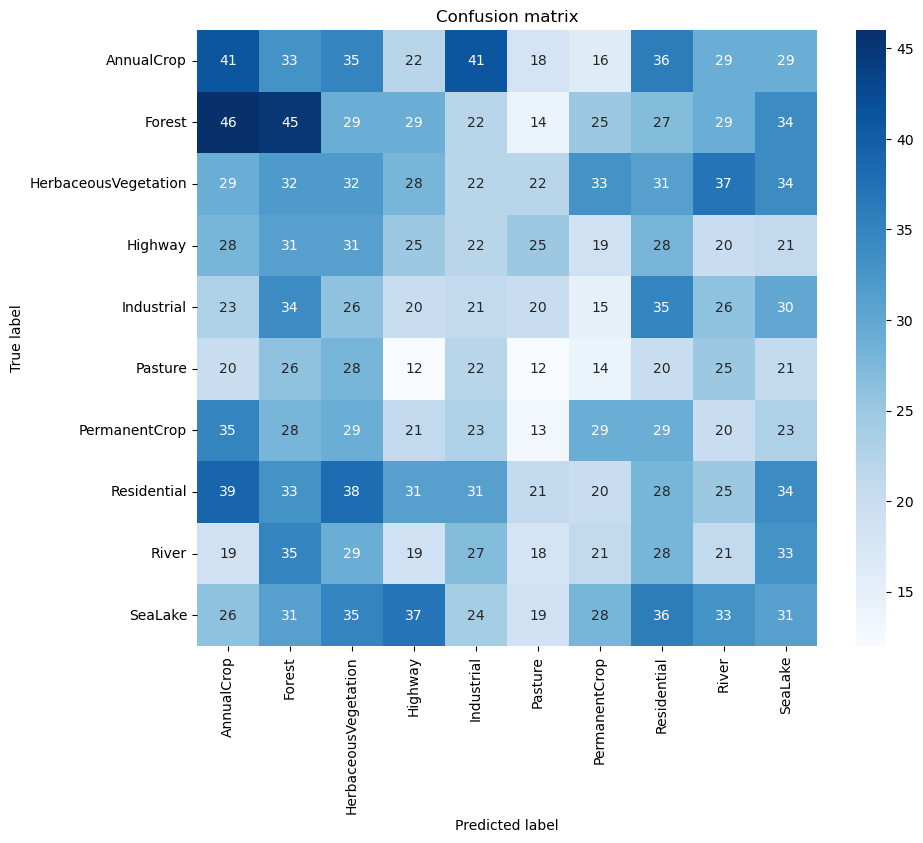

In [17]:
import seaborn as sns

# get the true labels
true_labels = val_data.classes

# get the model's predicted labels
pred_labels = loaded_model.predict(val_data)
pred_labels = np.argmax(pred_labels, axis=1)

# generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], yticklabels=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'])
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [18]:
# Use loadeed model for this
test_img = image.load_img('/Users/pabloalonsomedrano/Desktop/Eurosat/Eurosat/val/AnnualCrop/AnnualCrop_5.jpg', target_size=(64, 64))
img = image.img_to_array(test_img)
img = np.expand_dims(img, axis=0)
r = loaded_model.predict(img)
class_indices = test_data.class_indices
label_map = dict((v,k) for k,v in class_indices.items())
pred = label_map[np.argmax(r)]
print(pred)

1/1 [==============================] - 0s 112ms/step
SeaLake


In [19]:
# Use loadeed model for this
test_img = image.load_img('/Users/pabloalonsomedrano/Desktop/Eurosat/Eurosat/val/AnnualCrop/AnnualCrop_11.jpg', target_size=(64, 64))
img = image.img_to_array(test_img)
img = np.expand_dims(img, axis=0)
r = loaded_model.predict(img)
class_indices = test_data.class_indices
label_map = dict((v,k) for k,v in class_indices.items())
pred = label_map[np.argmax(r)]
print(pred)

1/1 [==============================] - 0s 33ms/step
SeaLake


In [20]:
# Use loadeed model for this
test_img = image.load_img('/Users/pabloalonsomedrano/Desktop/Eurosat/Eurosat/val/SeaLake/SeaLake_5.jpg', target_size=(64, 64))
img = image.img_to_array(test_img)
img = np.expand_dims(img, axis=0)
r = loaded_model.predict(img)
class_indices = test_data.class_indices
label_map = dict((v,k) for k,v in class_indices.items())
pred = label_map[np.argmax(r)]
print(pred)

1/1 [==============================] - 0s 24ms/step
SeaLake
